# ***Necessary Imports***

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
# for reading writing and visulaizing the image
import numpy as np 
import pandas as pd # read csv
import matplotlib.pyplot as plt  # plotting
from matplotlib import style
# for creating the model
import torch  
from time import time
import torch.nn as nn
from tqdm import tqdm

from torchsummary import summary
from torch import distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# ***Reading data***

In [3]:
data = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


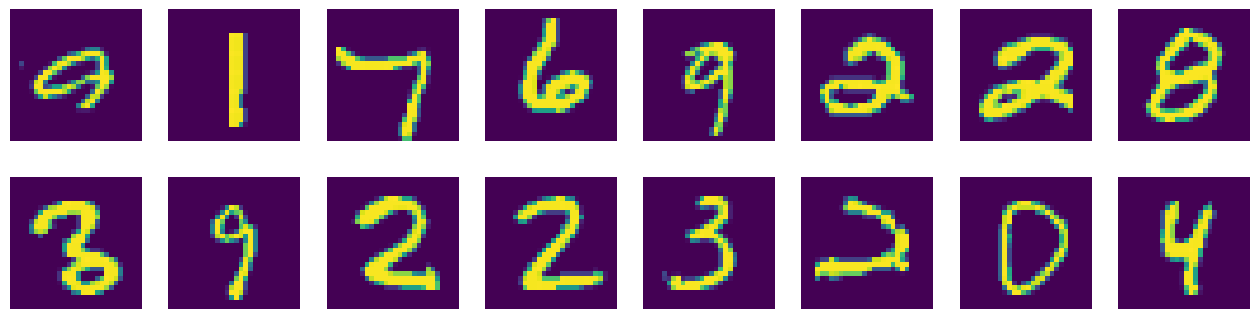

In [4]:
random_indices = np.random.randint(low=0, high=len(data), size=16)
figsize = plt.figure(figsize=(16,4))
for i,idx in enumerate(random_indices):
    plt.subplot(2,8,i+1)
    temp = data.iloc[idx, 1:].values
    plt.imshow(temp.reshape(28,28))
    plt.axis('off')
plt.show()

# ***Models***

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(784,512)
        self.linear2 = nn.Linear(512,2) # this term is for calculating mu
        self.linear3 = nn.Linear(512,2) # this term is for calculating sigma
        self.dist = distributions.Normal(0,1)
        '''we will sample vectors of latent space by renormalizing the sample vector of the normal 
        gaussian deistribution by mean and variance of data examples' distribution ''' 
        self.kl = 0  
        '''kl divergence loss term is for two purposes, first it will allow gradients to flow
        and secondly we need our distribution to be as close to N(0,1)'''
        
        
    def forward(self,x):
        op = self.relu(self.linear1(x))
        mu = self.linear2(op)
        sigma = torch.exp(self.linear3(op)) 
        sample = self.dist.sample(mu.shape).to(device)
        z = mu + sigma*sample
        self.kl = (mu**2 + sigma**2 - torch.log(sigma) -1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2,512),
            nn.ReLU(),
            nn.Linear(512,784),
            #nn.Sigmoid()
        )
        
    def forward(self,x):
        op = self.model(x)
        return op

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        
        
    def forward(self,x):
        op = self.encoder(x)
        op = self.decoder(op)
        return op

In [8]:
model = Autoencoder().to(device)
summary(model, (784, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                    [-1, 2]           1,026
            Linear-4                    [-1, 2]           1,026
           Encoder-5                    [-1, 2]               0
            Linear-6                  [-1, 512]           1,536
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 784]         402,192
           Decoder-9                  [-1, 784]               0
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.08
Estimated Total Size (MB): 3.11
-------------------------------------------

# ***Utils***

In [9]:
def save_checkpoint(state, filename='my_checkpoint.pth'):
    # will save model and optimizer params at every epoch
    print("-> Saving CheckPoint")
    torch.save(state, filename)

In [10]:
def load_checkpoint(checkpoint, model):
    # it will just load, we can train it further, make changes to the architecture
    # and simply use it to predict
    print("-> Loading CheckPoint")
    model.load_state_dict(checkpoint["state_dict"])

In [11]:
def train(loader, model, optimizer, scaler, scheduler, device=device):
    '''
    it is the training procedure for one epoch of the network
    '''
    losses = 0
    model.train()
    num_batches = len(loader)
    batches = tqdm(loader) # tqdm will be used to generate progress bars
    train_acc = 0
    for idx, batch in enumerate(batches, 0):
        inp = (batch/255.0).to(device)  # shape is (128, 784)
        
        # forward
        with torch.cuda.amp.autocast(): # for gradient underflowing and overflowing and it makes training faster by converting all floats to float16
            pred = model(inp)
            loss = ((pred - inp)**2).sum() + model.encoder.kl
            
        # making all the previous gradients zero 
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        batches.set_postfix(loss = loss.item()) # loss of this current batch on current iteration 
        losses+= loss.item()
    
    losses/=num_batches    
    scheduler.step()
    return losses

In [12]:
# this model's testing clearly depends upon how good the image visuals are
def test(model):
    model.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(16,4))
        for i in range(16):
            fig.add_subplot(2,8,i+1)
            noise = distributions.Normal(0,1).sample((1,2)).to(device)
            image = model.decoder(noise).reshape(28,28)
            image = image.cpu().detach().numpy()
            plt.imshow(image)
            plt.axis('off')
    plt.show()
    model.train()

# ***Driver Code***

In [20]:
# hparams
batch_size = 128
lr = 1e-3
num_epochs = 10

# setting up the data
train_data = data.iloc[:, 1:].values
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

# setting up the model, optimizer, scaler, scheduler
model = Autoencoder().to(device)
scaler = torch.cuda.amp.GradScaler() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
losses = []

100%|██████████| 469/469 [00:05<00:00, 92.51it/s, loss=4.22e+3] 


-> Saving CheckPoint


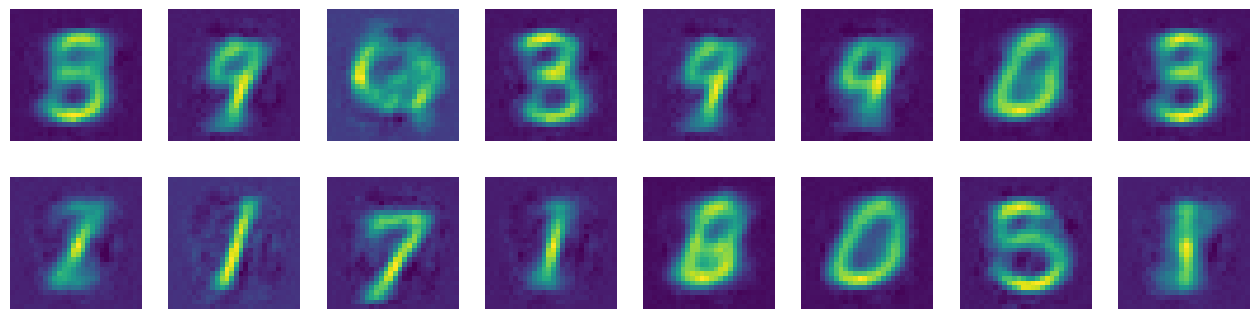

100%|██████████| 469/469 [00:04<00:00, 96.95it/s, loss=3.88e+3] 


-> Saving CheckPoint


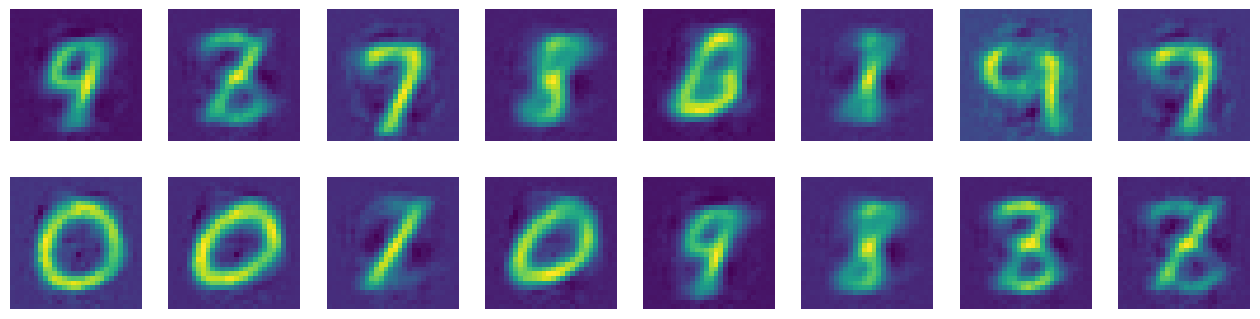

100%|██████████| 469/469 [00:05<00:00, 92.85it/s, loss=3.91e+3] 


-> Saving CheckPoint


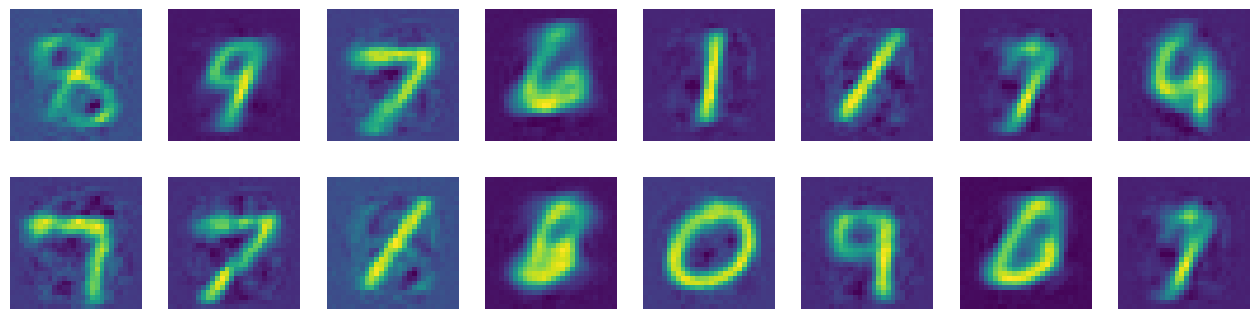

100%|██████████| 469/469 [00:05<00:00, 87.85it/s, loss=3.68e+3] 


-> Saving CheckPoint


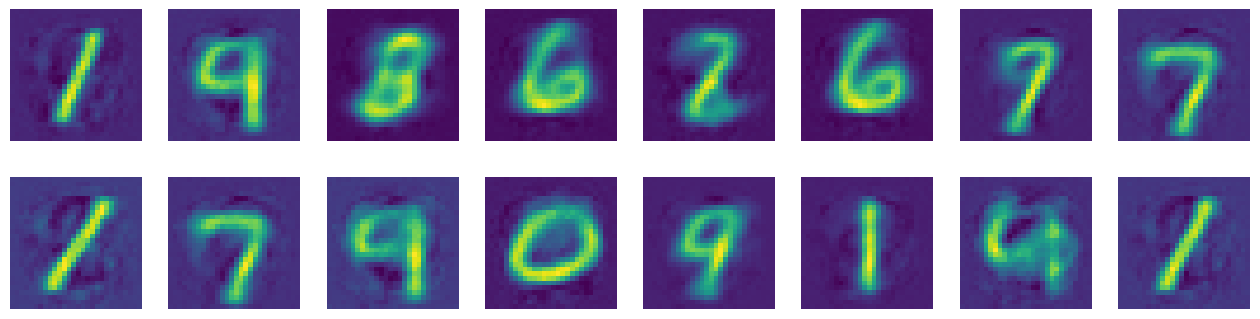

100%|██████████| 469/469 [00:05<00:00, 90.72it/s, loss=3.93e+3] 


-> Saving CheckPoint


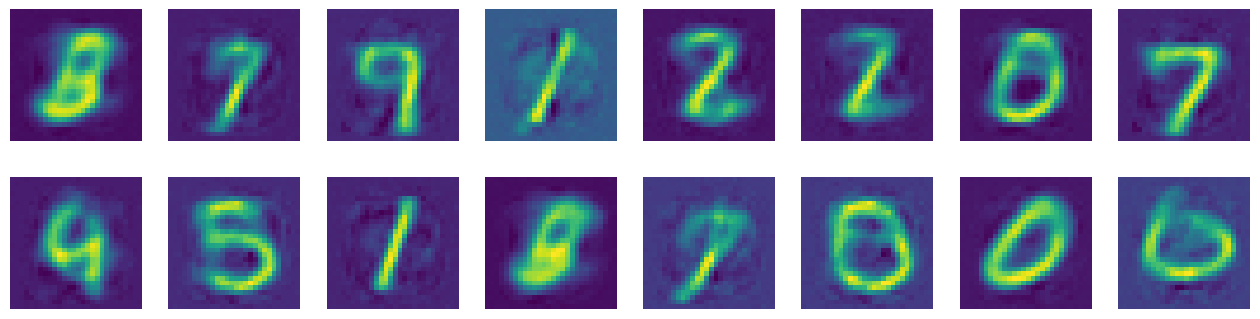

100%|██████████| 469/469 [00:04<00:00, 96.84it/s, loss=3.56e+3] 


-> Saving CheckPoint


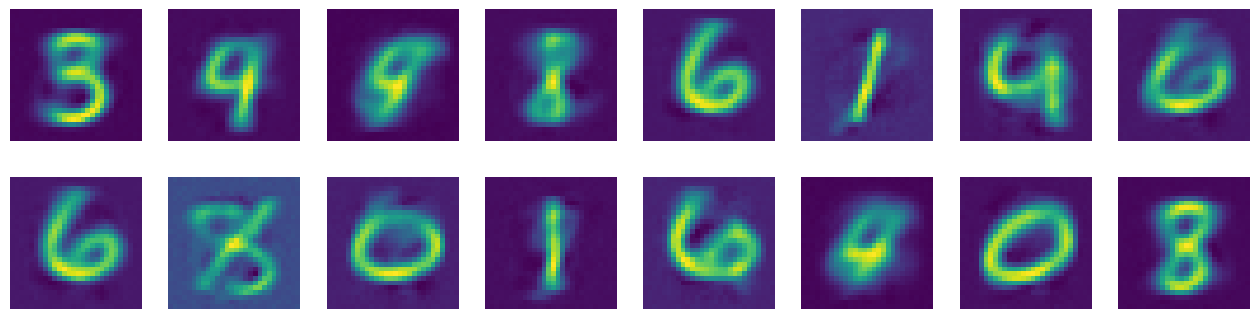

100%|██████████| 469/469 [00:05<00:00, 91.55it/s, loss=3.87e+3] 


-> Saving CheckPoint


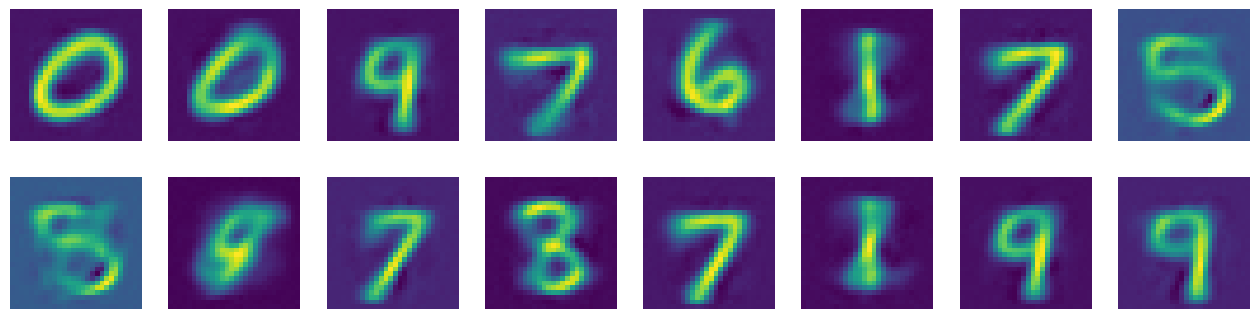

100%|██████████| 469/469 [00:04<00:00, 95.95it/s, loss=3.63e+3] 


-> Saving CheckPoint


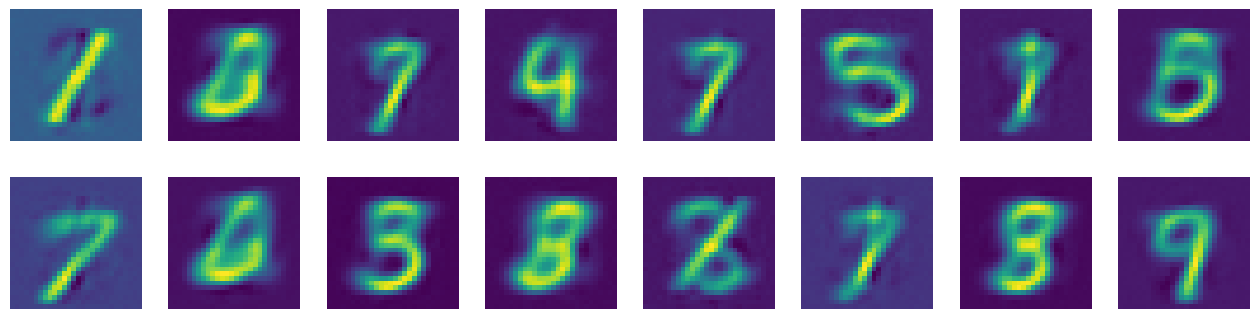

100%|██████████| 469/469 [00:05<00:00, 90.46it/s, loss=3.7e+3]  


-> Saving CheckPoint


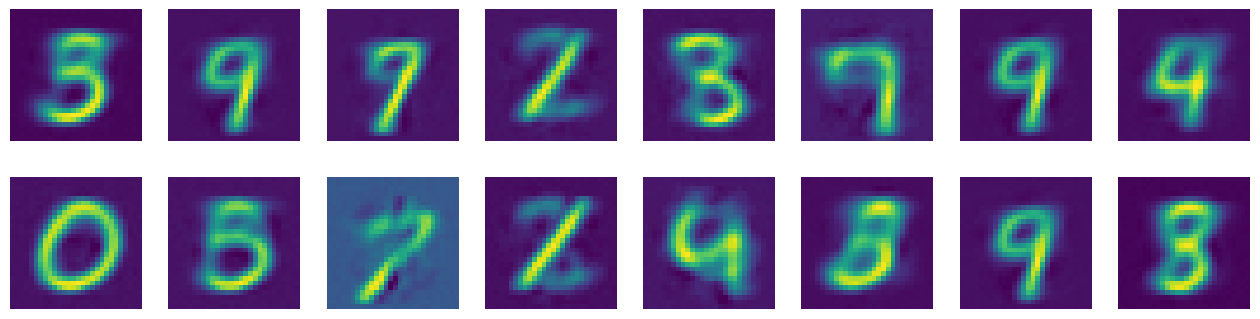

100%|██████████| 469/469 [00:05<00:00, 86.47it/s, loss=3.71e+3] 


-> Saving CheckPoint


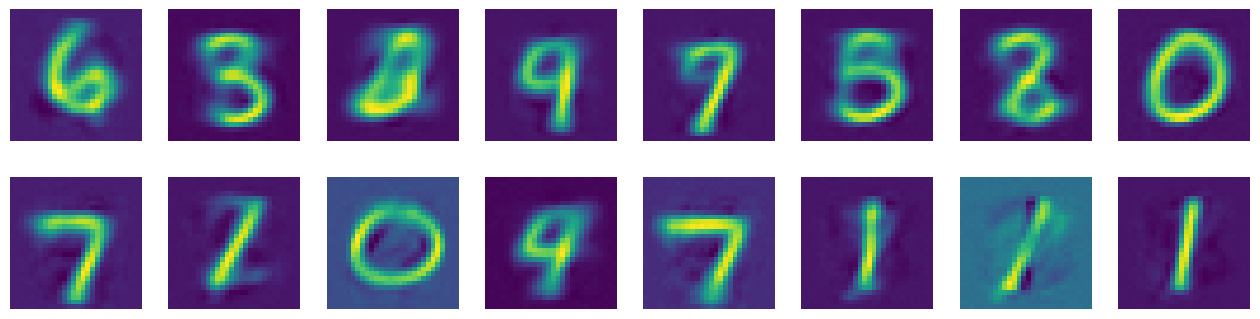

100%|██████████| 469/469 [00:05<00:00, 90.85it/s, loss=3.51e+3] 


-> Saving CheckPoint


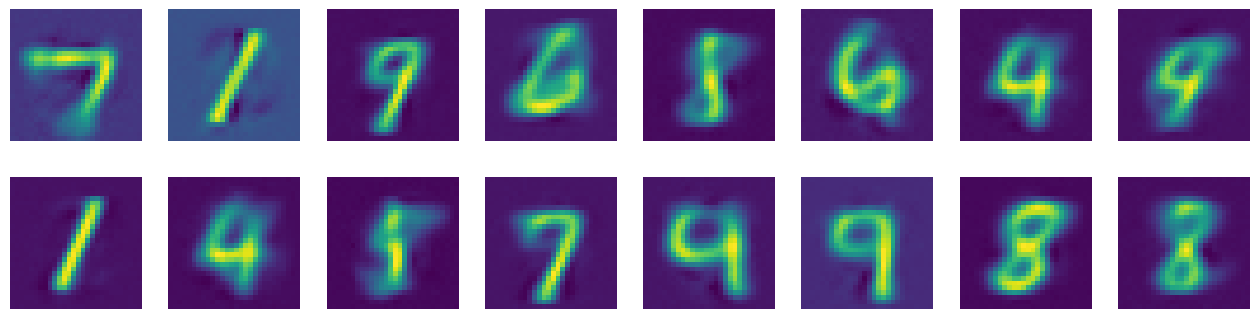

100%|██████████| 469/469 [00:04<00:00, 96.90it/s, loss=3.72e+3] 


-> Saving CheckPoint


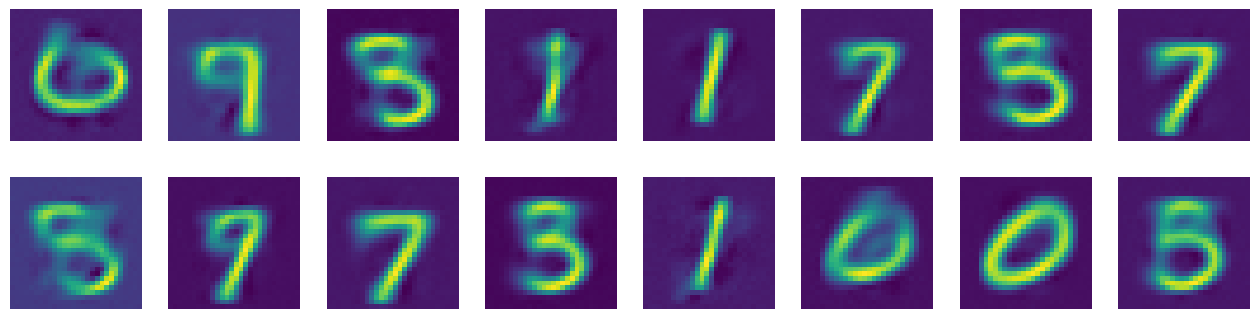

100%|██████████| 469/469 [00:05<00:00, 91.67it/s, loss=3.64e+3] 


-> Saving CheckPoint


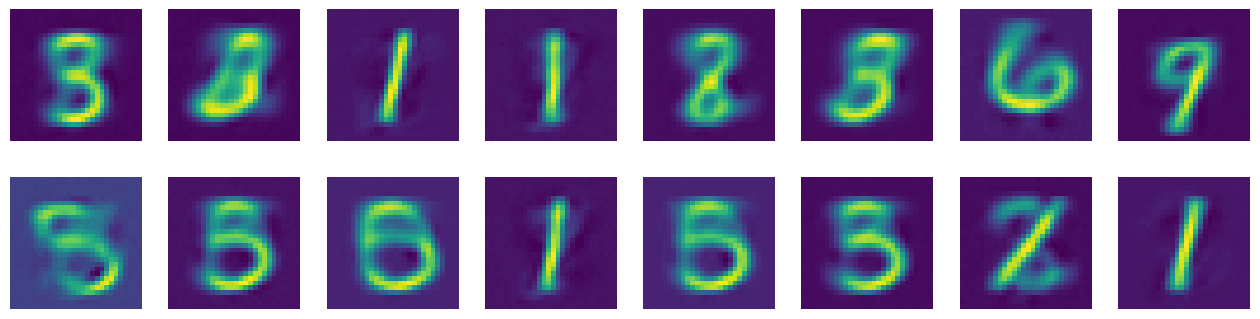

100%|██████████| 469/469 [00:04<00:00, 96.82it/s, loss=3.79e+3] 


-> Saving CheckPoint


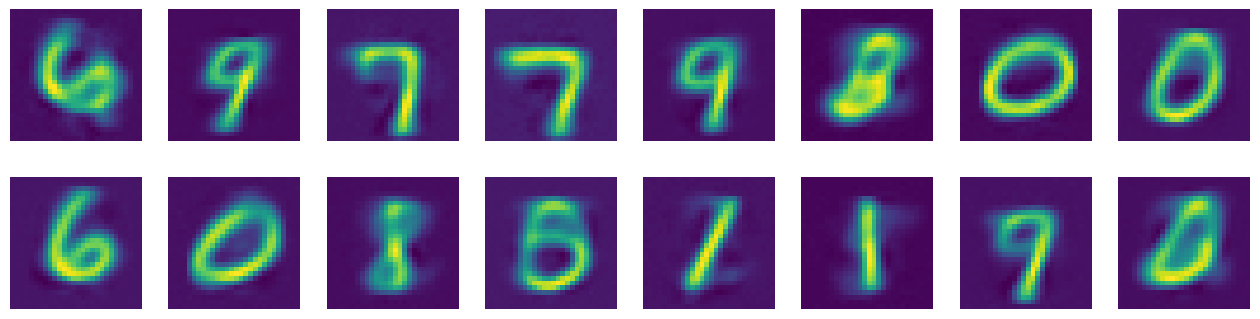

100%|██████████| 469/469 [00:05<00:00, 82.26it/s, loss=3.74e+3] 


-> Saving CheckPoint


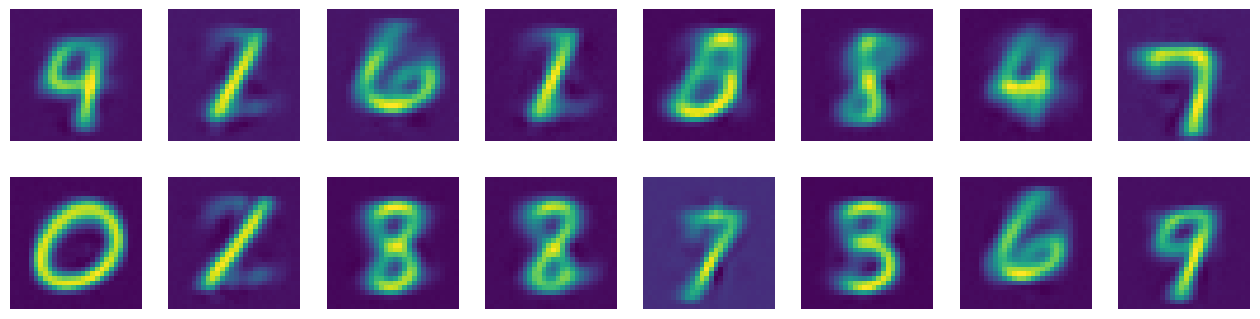

 96%|█████████▌| 449/469 [00:04<00:00, 69.13it/s, loss=4.84e+3] 

In [ ]:
for epoch in range(num_epochs):
    model.train()
    losses.append(train(train_loader, model, optimizer, scaler, scheduler))
    
    # save checkpoints 
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    # check accuracy  om test set
    test(model)

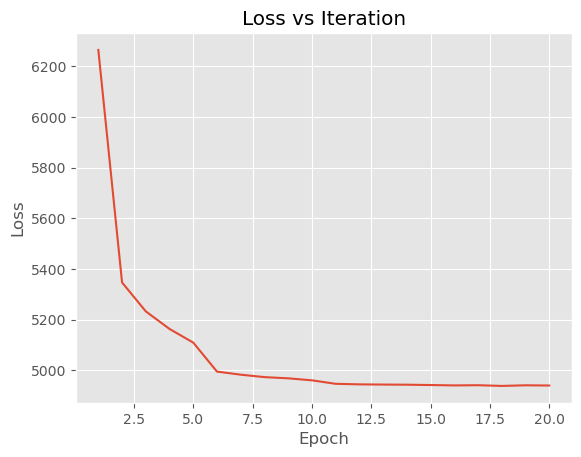

In [24]:
plt.plot(range(1, num_epochs+1), losses)
style.use('ggplot')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()